In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_parquet('../DATA/evictions_matched.parquet')

In [3]:
df.shape

(630393, 81)

In [4]:
## Set your desired match confidence here
confidence = 85
df = df.loc[df['match_confidence'] >= confidence]

In [5]:
df.head()

,plaintiff_name,defendant_name,defendant_zip,c2dp_case_id,county,fips,case_number,filed_date,case_type,debt_type,...,RA-Status,RA-Loc,StockInd,TotalShares,MergerInd,AssessInd,Is Series LLC,Is Protected Series,Series LLC ID,Name_normalized
0,"1 HIL MAR, INC","SCHOTT, HENRY J",23227.0,127_GV22000423-00,New Kent General District Court,127,GV22000423-00,2022-08-18,Unlawful Detainer,None,...,Active,810.0,NaN,NaN,None,1,None,None,None,hi
1,"1 HIL MAR, INC","SCHOTT, HENRY J",23227.0,127_GV22000423-00,New Kent General District Court,127,GV22000423-00,2022-08-18,Unlawful Detainer,None,...,Active,990.0,NaN,0.0,None,0,None,None,None,hi
2,1 SQ APTS LP,AYALA ERICA,23702.0,740_GV18012249-00,Portsmouth General District Court,740,GV18012249-00,2018-11-21,Unlawful Detainer,None,...,Active,510.0,NaN,NaN,None,1,None,None,None,apt
3,1 SQ APTS LP,DARDEN DAVID,23702.0,740_GV18012250-00,Portsmouth General District Court,740,GV18012250-00,2018-11-26,Unlawful Detainer,None,...,Active,510.0,NaN,NaN,None,1,None,None,None,apt
4,1 SQ APTS LP,GROOMS SHAVON,23702.0,740_GV18012251-00,Portsmouth General District Court,740,GV18012251-00,2018-11-26,Unlawful Detainer,None,...,Active,510.0,NaN,NaN,None,1,None,None,None,apt


In [6]:
df.columns

Index(['plaintiff_name', 'defendant_name', 'defendant_zip', 'c2dp_case_id',
       'county', 'fips', 'case_number', 'filed_date', 'case_type', 'debt_type',
       'defendant_attorney', 'defendant_dba_ta', 'defendant_address',
       'defendant_count', 'all_defendant_names', 'all_defendant_addresses',
       'defendant_order_validation', 'hearing_count', 'latest_hearing_date',
       'latest_hearing_result', 'judgment', 'homestead_exemption_waived',
       'is_judgment_satisfied', 'date_satisfaction_filed',
       'further_case_information', 'costs', 'attorney_fees',
       'principal_amount', 'interest_award', 'possession',
       'writ_of_eviction_issued_date', 'other_amount', 'other_awarded',
       'clean_party_name', 'plaintiff_attorney', 'plaintiff_dba_ta',
       'plaintiff_address', 'plaintiff_count', 'all_plaintiff_names',
       'all_plaintiff_addresses', 'plaintiff_order_validation', 'filed_year',
       'filed_quarter', 'plaintiff_zip', 'serial_filing',
       'latest_filing

In [7]:
### Heuristic Matching
# Group by Registered Agent (RA-Name)
ra_groups = df.groupby('RA-Name').size().reset_index(name='LLC_Count')
ra_groups = ra_groups.sort_values(by='LLC_Count', ascending=False)

# Group by Address (Street1)
address_groups = df.groupby('Street1').size().reset_index(name='LLC_Count')
address_groups = address_groups.sort_values(by='LLC_Count', ascending=False)

# Group by composite key: RA-Name + Street1
df['Composite_Key'] = df['RA-Name'] + '|' + df['Street1']
composite_groups = df.groupby('Composite_Key').size().reset_index(name='LLC_Count')
composite_groups = composite_groups.sort_values(by='LLC_Count', ascending=False)

In [8]:
print("Top groups by Registered Agent:")
print(ra_groups.head(10))

Top groups by Registered Agent:
                                     RA-Name  LLC_Count
1247             CORPORATION SERVICE COMPANY      38404
901                   C T CORPORATION SYSTEM      26385
312                          ARVIND B   AMIN      12839
2795                          HORACE   JONES      11586
2883                             ICAFS  INC.      10694
7489              Vcorp Agent Services  Inc.      10372
5418        NATIONAL REGISTERED AGENTS  INC.       8185
7090                         THAO NHU   DINH       7786
7415  United States Corporation Agents  Inc.       7398
423                         Alperin Law PLLC       4071


In [9]:
print("Top groups by Street1:")
print(address_groups.head(10))

Top groups by Street1:
                         Street1  LLC_Count
3663         208 GOLDEN MAPLE DR      12839
2548        1555 KING ST STE 200      11586
8039  6031 Connection Dr Ste 200       8786
8966         7704-C RICHMOND HWY       7786
4966          2922 Hathaway Road       5077
2616          160 CLUBHOUSE ROAD       4042
7753          560 LYNNHAVEN PKWY       3745
733      11 South Cameron Street       3663
6909   46400 BENEDICT DR STE 201       3663
7755       560 Lynnhaven Parkway       3454


In [10]:
print("Top groups by Composite Key:")
print(composite_groups.head(10))

Top groups by Composite Key:
                                       Composite_Key  LLC_Count
363              ARVIND B   AMIN|208 GOLDEN MAPLE DR      12839
3992             HORACE   JONES|1555 KING ST STE 200      11586
9380             THAO NHU   DINH|7704-C RICHMOND HWY       7786
4113                  ICAFS  INC.|2922 Hathaway Road       5077
1889  CORPORATION SERVICE COMPANY|160 CLUBHOUSE ROAD       4042
7139      NATE L  ADAMS  III|11 South Cameron Street       3663
3261      ESMAIL   SHIRAZI|46400 BENEDICT DR STE 201       3663
9432   THOMAS G.  JOHNSON  JR.|560 Lynnhaven Parkway       3454
5845                Kenneth  W Hudson|2060 Meadow Rd       3432
4111                    ICAFS  INC.|2922 HATHAWAY RD       3340


A more robust approach

In [11]:
ra_groups = df.groupby('RA-Name').agg({
    'Name': 'count',
    'plaintiff_name': lambda x: list(x),
    'IncorpDate': lambda x: list(x),
    'Zip': lambda x: list(x),
    'filed_date': lambda x: list(x),
    'serial_filing': lambda x: list(x)
}).rename(columns={'Name': 'LLC_Count'}).reset_index()
ra_groups = ra_groups.loc[ra_groups['LLC_Count'] > 1]

In [12]:
address_groups = df.groupby('Street1').agg({
    'Name': 'count',
    'plaintiff_name': lambda x: list(x),
    'IncorpDate': lambda x: list(x),
    'Zip': lambda x: list(x),
    'filed_date': lambda x: list(x),
    'serial_filing': lambda x: list(x)
}).rename(columns={'Name': 'LLC_Count'}).reset_index()
address_groups = address_groups.loc[address_groups['LLC_Count'] > 1]

In [13]:
df['Composite_Key'] = df['RA-Name'] + '|' + df['Street1']
composite_groups = df.groupby('Composite_Key').agg({
    'Name': 'count',
    'plaintiff_name': lambda x: list(x),
    'IncorpDate': lambda x: list(x),
    'Zip': lambda x: list(x),
    'filed_date': lambda x: list(x),
    'serial_filing': lambda x: list(x)
}).rename(columns={'Name': 'LLC_Count'}).reset_index()
composite_groups = composite_groups.loc[composite_groups['LLC_Count'] > 1]

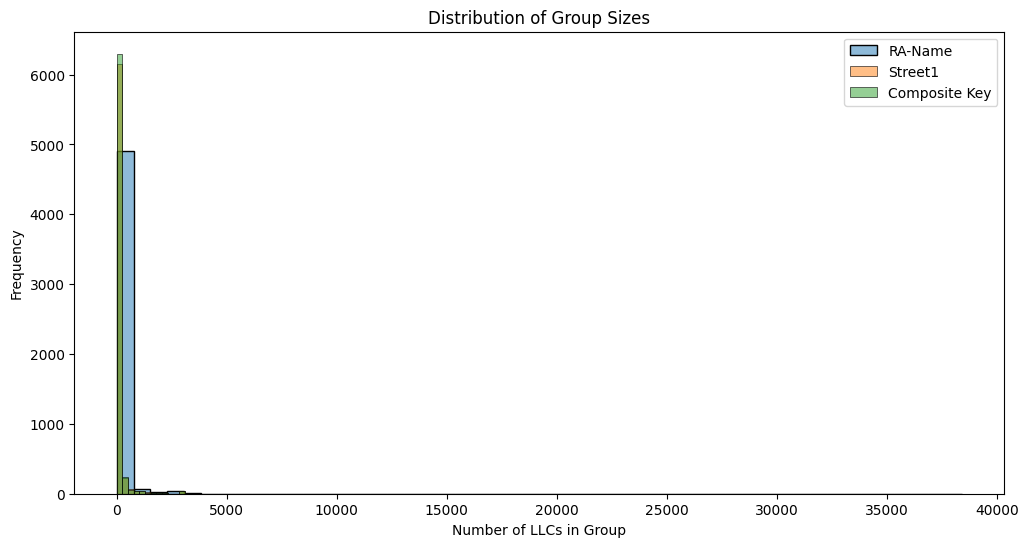

In [14]:
plt.figure(figsize=(12, 6))
sns.histplot(ra_groups['LLC_Count'], bins=50, label='RA-Name', alpha=0.5)
sns.histplot(address_groups['LLC_Count'], bins=50, label='Street1', alpha=0.5)
sns.histplot(composite_groups['LLC_Count'], bins=50, label='Composite Key', alpha=0.5)
plt.xlabel('Number of LLCs in Group')
plt.ylabel('Frequency')
plt.title('Distribution of Group Sizes')
plt.legend()
plt.savefig('group_size_distribution.png')
plt.show()
plt.close()

In [ ]:
print("Top 5 RA-Name Groups (LLC_Count > 1):")
print(ra_groups[['RA-Name', 'LLC_Count']].sort_values(by='LLC_Count', ascending=False).head(5))
print("\nTop 5 Street1 Groups (LLC_Count > 1):")
print(address_groups[['Street1', 'LLC_Count']].sort_values(by='LLC_Count', ascending=False).head(5))
print("\nTop 5 Composite Key Groups (LLC_Count > 1):")
print(composite_groups[['Composite_Key', 'LLC_Count']].sort_values(by='LLC_Count', ascending=False).head(5))

Top 5 RA-Name Groups (LLC_Count > 1):
                          RA-Name  LLC_Count
1247  CORPORATION SERVICE COMPANY      38404
901        C T CORPORATION SYSTEM      26385
312               ARVIND B   AMIN      12839
2795               HORACE   JONES      11586
2883                  ICAFS  INC.      10694

Top 5 Street1 Groups (LLC_Count > 1):
                         Street1  LLC_Count
3663         208 GOLDEN MAPLE DR      12839
2548        1555 KING ST STE 200      11586
8039  6031 Connection Dr Ste 200       8786
8966         7704-C RICHMOND HWY       7786
4966          2922 Hathaway Road       5077

Top 5 Composite Key Groups (LLC_Count > 1):
                                       Composite_Key  LLC_Count
363              ARVIND B   AMIN|208 GOLDEN MAPLE DR      12839
3992             HORACE   JONES|1555 KING ST STE 200      11586
9380             THAO NHU   DINH|7704-C RICHMOND HWY       7786
4113                  ICAFS  INC.|2922 Hathaway Road       5077
1889  CORPORATION SERVIC

: 

In [ ]:
ra_entities = df.merge(ra_groups[['RA-Name']], on='RA-Name', how='inner')[['Name', 'RA-Name', 'plaintiff_name']]
address_entities = df.merge(address_groups[['Street1']], on='Street1', how='inner')[['Name', 'Street1', 'plaintiff_name']]

overlap = pd.merge(
    ra_entities,
    address_entities,
    on='Name',
    how='inner',
    suffixes=('_ra', '_addr')
)
print("\nNumber of overlapping LLCs (RA-Name and Street1):", len(overlap))
print("Sample overlapping LLCs (first 5):")
print(overlap[['Name', 'RA-Name', 'Street1', 'plaintiff_name_ra']].head(5))